In [370]:
import numpy as np
from sympy import *
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy as sp
from scipy.optimize import minimize

from numba import jit

In [496]:
def log_interp1d(xx, yy, neg=False,kind='linear'):

    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: -np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

"""
def solve_polynome(polynome,epsilon = 1e-8):

    left = 0
    right= 1

    while right-left>epsilon :

        mid = (left+right) / 2
        if (polynome(left))*(polynome(mid)) < 0:
            right = mid
        else:
            left = mid

    return left
"""


def bonds_probability_of_default(coupon, maturity_years, bond_price, risk_adjusted_discount_rate, indexes, principal_payment=100):

    #if indexes%50==0:
    #    print("{}% done".format(round(100*indexes/667,3)))
    #print("{}/667".format(indexes))
    print("============================")
    print('risk discount rate = ',risk_adjusted_discount_rate)
    
        
        
    price = bond_price
    prob_default_exp = 0
    

    times = np.arange(1, maturity_years+1) 
    annual_coupon = coupon 

    
    
    # Calculation of Expected Cash Flow
    cashflows = np.array([])

    for i in times[:-1]:
            cashflows = np.append(cashflows, annual_coupon)
    cashflows = np.append(cashflows, annual_coupon+principal_payment)
            


    def polynome(P):
        x_prob_default_exp = 0
        for i in range(len(times)):

            #if there is only one payment remaining
            if len(times) == 1:
                x_prob_default_exp += ((cashflows[i]*(1-P) + cashflows[i]*recovery_rate*P) / \
                                    np.power((1 + risk_adjusted_discount_rate), times[i]))

            #if there are multiple payments remaining
            else:

                if times[i] == 1:
                    x_prob_default_exp += ((cashflows[i]*(1-P) + principal_payment*recovery_rate*P) / \
                                            np.power((1 + risk_adjusted_discount_rate), times[i]))


                else:
                    x_prob_default_exp += (np.power((1-P), times[i-1])*(cashflows[i]*(1-P) + principal_payment*recovery_rate*P)) / \
                                        np.power((1 + risk_adjusted_discount_rate), times[i])
        
        return (x_prob_default_exp - price)**2
    
    #Ps = np.linspace(0,1,30)
    #plt.plot(Ps,np.vectorize(polynome)(Ps))
    #plt.show()

    implied_prob_default = minimize(polynome, x0=np.array([.5]))
    #prob_default_exp = solve_polynome(polynome=polynome)
        
        
        
        
    #implied_prob_default = solve(prob_default_exp, P,quick=True,warn=True,minimal=True)
    
    #if len(implied_prob_default)>0:
    #    implied_prob_default = round(float(implied_prob_default['res']) * 100, 2)
    #else:
    #    return 0.0
    

    return max(0.0,implied_prob_default.x)

In [497]:
df = pd.read_csv('bonds_complets.csv')

df = df[df['Maturity'].notna()]
df.columns

Index(['Unnamed: 0', 'Reference Security', 'Ticker_x', 'Bid Price',
       'Ask Price', 'Mid Price', 'Issuer Name', 'Cpn', 'Maturity', 'Ticker_y',
       'Average Equity / Average Assets', 'Common Eqty / Tot Assets',
       'Debt / Common Equity', 'Debt/Assets', 'Debt/EBITDA', 'EBITDA',
       'Int Exp / Avg Int Bear Liab', 'Tot Debt / Tot Capital',
       'Tot Loans to Tot Assets', 'Tot Risk-Based Cap',
       'Earnings Assets / Int Bear Liab',
       'Total Expenses to Average Earning Assets'],
      dtype='object')

In [498]:
d_factor = pd.read_excel("DF(t) .xlsx")
d_factor.columns=['date','df']
def foo(x):
    
    now = datetime.strptime('2021-07-29','%Y-%m-%d')
    #now=datetime.now()
    return ((x-now).days)/365
d_factor['date'] = d_factor['date'].apply(foo)

z = 1/d_factor['date']*np.log(d_factor['df'])
print(z)
discount_rate = log_interp1d(d_factor['date'], z,)

0       -0.000000
1       -0.000000
2       -0.000000
3       -0.000000
4       -0.000000
           ...   
18257    0.001354
18258    0.001354
18259    0.001354
18260    0.001355
18261    0.001355
Length: 18262, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [499]:

recovery_rate = .40
P = symbols('P')

(0.0, 0.1)

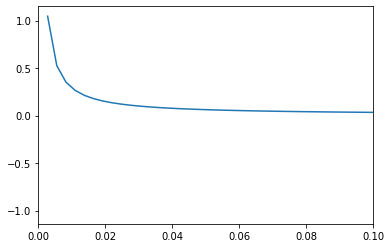

In [500]:
plt.plot(d_factor['date'], z,)
plt.xlim(0,.1)

In [501]:
def to_date(string):
    
    dt = datetime.strptime(string,'%m/%d/%Y')
    now = datetime.strptime('2021-07-29','%Y-%m-%d')
    #now=datetime.now()
    
    return (dt-now).days/365
df['maturity_years'] = df['Maturity'].apply(to_date)
DR = np.vectorize(discount_rate)(df['maturity_years'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


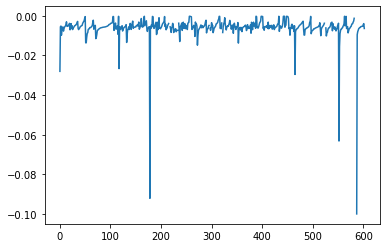

In [502]:
plt.plot(DR)

In [503]:

def compute_PD(coupons,maturity_years,prices,DR,indexes):
    PDS=[]
    with open('pd.txt','w') as fichier:
        for i in range(len(DR)):
            pd = bonds_probability_of_default(coupons[i],maturity_years[i],prices[i],DR[i],indexes[i])
            PDS.append(pd)
            fichier.write(str(pd))
            fichier.write("\n")
    return PDS

In [504]:
PD = compute_PD(np.array(df['Cpn']),np.array(df['maturity_years']),np.array(df['Mid Price']),DR,np.array(df['Unnamed: 0']))







risk discount rate =  -0.028013758337432273
risk discount rate =  -0.005550594518423623
risk discount rate =  -0.00518712731441227
risk discount rate =  -0.009783852329696814
risk discount rate =  -0.007167667663091805
risk discount rate =  -0.005797819899726688
risk discount rate =  -0.005623087829424964
risk discount rate =  -0.00773482550829256
risk discount rate =  -0.006585846208089121
risk discount rate =  -0.00574244305620785
risk discount rate =  -0.005389979128989547
risk discount rate =  -0.005061143730902933
risk discount rate =  -0.00427141796563694
risk discount rate =  -0.003027362632491193
risk discount rate =  -0.005333324009996523
risk discount rate =  -0.005234287357234257
risk discount rate =  -0.005218356941239583
risk discount rate =  -0.004997066542676317
risk discount rate =  -0.004468946468887083
risk discount rate =  -0.0038235413727601497
risk discount rate =  -0.007073989751594163
risk discount rate =  -0.006384648126440851
risk discount rate =  -0.0039370424

risk discount rate =  -0.026634641046212906
risk discount rate =  -0.005542556590823362
risk discount rate =  -0.0055803566218721274
risk discount rate =  -0.006920638519076664
risk discount rate =  -0.0058960626267829845
risk discount rate =  -0.00574244305620785
risk discount rate =  -0.005004521285249496
risk discount rate =  -0.0076808892873580625
risk discount rate =  -0.0066662638492821094
risk discount rate =  -0.006286408361688428
risk discount rate =  -0.005842748871237177
risk discount rate =  -0.005686434878462087
risk discount rate =  -0.005387479269332863
risk discount rate =  -0.005211594704189951
risk discount rate =  -0.004475516260142165
risk discount rate =  -0.013440565644098332
risk discount rate =  -0.009458469204379134
risk discount rate =  -0.007092019440683149
risk discount rate =  -0.006548676208189548
risk discount rate =  -0.005573081467349046
risk discount rate =  -0.006933324403508071
risk discount rate =  -0.005614380147696997
risk discount rate =  -0.0038

risk discount rate =  -0.004480456270276131
risk discount rate =  -0.003671313646368178
risk discount rate =  -0.007373506340208263
risk discount rate =  -0.0039000460975205722
risk discount rate =  -0.0032376357891630383
risk discount rate =  -0.006314109930838075
risk discount rate =  -0.0049402424832470804
risk discount rate =  -0.003941522150561277
risk discount rate =  -0.00649755670990488
risk discount rate =  -0.006089093589652202
risk discount rate =  -0.00494316738150044
risk discount rate =  -0.00494316738150044
risk discount rate =  -0.006925691032015086
risk discount rate =  -0.003943017331229604
risk discount rate =  -0.003453348381040441
risk discount rate =  -0.0033099398158210336
risk discount rate =  -0.00026726533230142757
risk discount rate =  -0.00023107590478679046
risk discount rate =  -0.00032560936669112227
risk discount rate =  -0.0004548099825058372
risk discount rate =  -0.0004955898726986522
risk discount rate =  -0.006879394448379429
risk discount rate =  -

risk discount rate =  -0.0074390965203627885
risk discount rate =  -0.006589654068078853
risk discount rate =  -0.004468946468887083
risk discount rate =  -0.00598770734943096
risk discount rate =  -0.005634089330653487
risk discount rate =  -0.006425686468823264
risk discount rate =  -0.006179932199033186
risk discount rate =  -0.005796829156919287
risk discount rate =  -0.00457444760293253
risk discount rate =  -0.00878566751424505
risk discount rate =  -0.003267158756229933
risk discount rate =  -0.004921350668833989
risk discount rate =  -0.007010664422548729
risk discount rate =  -0.004053801817988529
risk discount rate =  -0.003229263743971068
risk discount rate =  -0.005177263672630408
risk discount rate =  -0.004297045416158436
risk discount rate =  -0.0038824975910154457
risk discount rate =  -0.006278688075160873
risk discount rate =  -0.0002283910920918535
risk discount rate =  -0.0004331052806561971
risk discount rate =  -0.005934092069514483
risk discount rate =  -0.005934

risk discount rate =  -0.0027401126742384227
risk discount rate =  -0.006908132831867277
risk discount rate =  -0.009748913649847087
risk discount rate =  -0.009714543078612537
risk discount rate =  -0.006791704064052358
risk discount rate =  -0.006645621242829919
risk discount rate =  -0.006342918508459797
risk discount rate =  -0.0063345706789665265
risk discount rate =  -0.005986449805635471
risk discount rate =  -0.0059051185394390915
risk discount rate =  -0.005674805618371004
risk discount rate =  -0.005557688058506203
risk discount rate =  -0.004909827344761177
risk discount rate =  -0.0033534494770515056
risk discount rate =  -0.002758578763400146
risk discount rate =  -0.000300268362748007
risk discount rate =  -0.009041912172616238
risk discount rate =  -0.00795865024944112
risk discount rate =  -0.007473371088187779
risk discount rate =  -0.0072855713188868946
risk discount rate =  -0.007119709942476326
risk discount rate =  -0.006570782146591394
risk discount rate =  -0.006

In [505]:
#df.sort_values('maturity_years',inplace=True)


In [483]:
df['PD_1y'] = PD

In [485]:
df.head(20)

,Unnamed: 0,Reference Security,Ticker_x,Bid Price,Ask Price,Mid Price,Issuer Name,Cpn,Maturity,Ticker_y,...,Debt/EBITDA,EBITDA,Int Exp / Avg Int Bear Liab,Tot Debt / Tot Capital,Tot Loans to Tot Assets,Tot Risk-Based Cap,Earnings Assets / Int Bear Liab,Total Expenses to Average Earning Assets,maturity_years,PD_1y
223,223,EI641880 Corp,AIRBR,0.083,1.372,0.7275,Air Berlin PLC,8.250,04/19/2018,AIRBR,...,NaN,-629.081,NaN,NaN,NaN,NaN,NaN,NaN,-3.279452,[0.5]
263,263,AF279066 Corp,ALITSA,2.500,10.300,6.4000,Alitalia-Societa Aerea Italiana SpA,5.250,07/30/2020,ALITSA,...,0.00000,0.400,NaN,0.0000,NaN,NaN,NaN,NaN,-0.997260,[0.5]
652,652,EF602484 Corp,BBVASM,0.200,NaN,NaN,Banco Bilbao Vizcaya Argentaria SA,0.548,08/09/2021,BBVASM,...,NaN,NaN,NaN,79.4593,43.9004,58147.0,194.614,NaN,0.030137,[0.5]
198,198,QZ147818 Corp,AGGHOL,98.676,101.850,100.2630,Aggregate Holdings SA,5.000,08/10/2021,AGGHOL,...,6.13055,335.193,NaN,49.9001,NaN,NaN,NaN,NaN,0.032877,[0.0907612435661803]
612,612,AO644270 Corp,BATSLN,100.017,100.022,100.0195,BAT Capital Corp,-0.047,08/16/2021,BATSLN,...,4.04294,11383.000,NaN,41.1212,NaN,NaN,NaN,NaN,0.049315,[0.010845203871118536]
519,519,EK472649 Corp,BAC,100.199,100.216,100.2075,Bank of America Corp,1.375,09/10/2021,BAC,...,NaN,NaN,0.285286,66.1928,33.2350,237936.0,148.990,NaN,0.117808,[0.028746156498557284]
0,0,AU053739 Corp,AABHFH,100.086,100.098,100.0920,Alandsbanken Abp,0.500,09/13/2021,AABHFH,...,NaN,NaN,NaN,87.2526,72.7382,275.5,NaN,NaN,0.126027,[0.016099935353955475]
135,135,EK398481 Corp,ACKAF,100.312,100.452,100.3820,Arcelik AS,3.875,09/16/2021,ACKAF,...,3.07702,5273.640,NaN,54.9059,NaN,NaN,NaN,NaN,0.134247,[0.06850280312261352]
613,613,EI865065 Corp,BATSLN,101.075,101.121,101.0980,BAT International Finance PLC,3.625,11/09/2021,BATSLN,...,21.36510,912.000,3.355120,88.5682,87.7605,NaN,203.958,NaN,0.282192,[0.05135208383281192]
305,305,QJ093741 Corp,AMSSM,100.167,100.328,100.2475,Amadeus Capital Markets SA,1.625,11/17/2021,AMSSM,...,NaN,58.600,NaN,60.2239,NaN,NaN,NaN,NaN,0.304110,[0.03203223473951633]


In [455]:
df['PD_1y'] = df['PD_1y'].apply(arrangement)

In [453]:
def arrangement(x):
    x=str(x)
    x=x.replace('[','')
    x=x.replace(']','')
    x=float(x)
    x=round(x,4)
    return x

In [456]:
df.to_csv('bounds_with_pd.csv')